#### Company stock analysis with Monte-Carlo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [2]:
def get_company_data(company_name, start_date, end_date):
    """Read from CSV file and obtain specified company data

    Parameters
    ---------
    company_name: in set `{'A', 'AA', 'ABC', 'ABCB', 'ACLS',
    'ACNB', 'ADBE', 'ADP', 'AEG', 'AIR'}`

    Returns
    -------
    Pandas Dataframe with indexes: Date, company name
    """
    assert company_name in [
        'A', 'AA', 'ABC', 'ABCB', 'ACLS',
        'ACNB', 'ADBE', 'ADP', 'AEG', 'AIR'
    ], f"Company stock data not found"
    company_string = '..\\data\\' + company_name + '.csv'
    data = pd.read_csv(company_string, parse_dates=['Date'])
    data['Date'] = pd.to_datetime(data['Date'])
    # drop columns except "Date, close price"
    data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
    return data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

In [7]:
end_time = dt(2019, 1, 1)
start_time = dt(2014, 1, 1)
company_list = ['A', 'AA', 'ABC', 'ABCB', 'ACLS','ACNB', 'ADBE', 'ADP', 'AEG', 'AIR']
stock_price, start_price = [], []
for company_name in company_list:
    company_data = get_company_data(company_name, start_time, end_time)
    start_price.append(company_data.tail(1)['Close'].values)
    # compute fractional change of current and previous for measuring changes
    # which is given as (next - previous) / previous
    stock_data = np.array(company_data['Close'].pct_change().dropna())
    stock_price.append(stock_data)
price_array = np.array(stock_price)
price_series = pd.DataFrame(price_array.T, columns=company_list)
start_price = np.array(start_price).flatten()

#### Visualizing data with heat maps

e:\Software_files\anaconda\envs\python_deepLearning\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


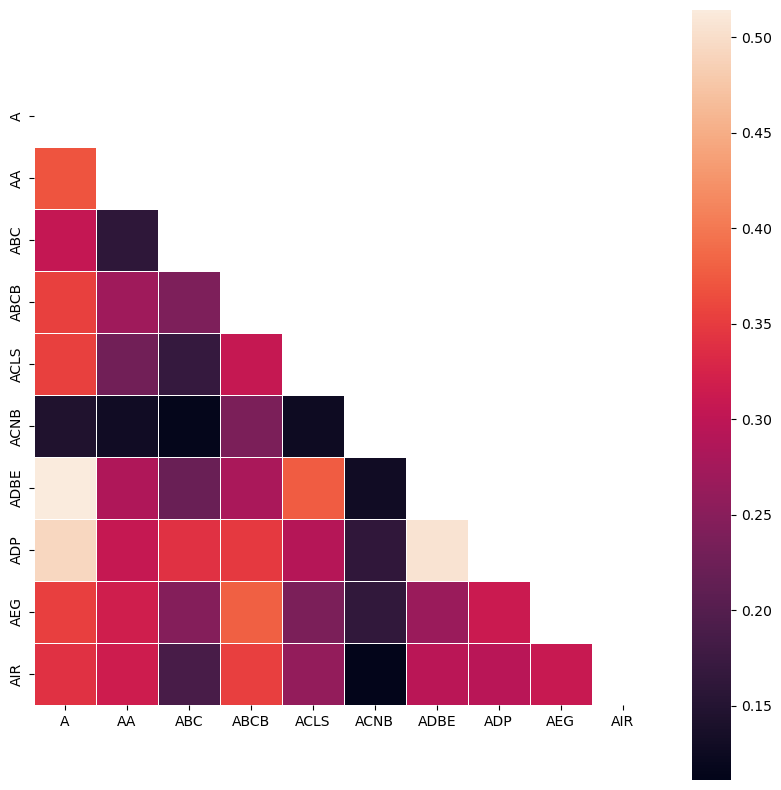

In [4]:
covMat = price_series.corr()
mask = np.triu(np.ones_like(covMat, dtype=bool))
plt.figure(figsize=(10,10))
sns.heatmap(covMat, mask=mask, square=True, linewidths=.5, annot=True, fmt='.2f')
plt.show()

#### Examine risk and profitability with Sharpe Ratio
- Intuitively, assign smaller weights to stocks with larger flunctuation
- Total profit being weight applied to each stock times stock price
  - $\mathbb{E}(R_p) = \sum_{i=1}^{n}w_iR_i$
  - $\rho_{\pi}= \sqrt{\sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}Cov(R_i, R_j)}$
were profit and risk, respectively, wish to **minimize** risk while **maximizing** profit, tantamount to
$min \frac{\rho}{\mathbb{E}}$ which is the **Sharpe Ratio**

In [5]:
mean_income = price_series.mean()
cov_returns = price_series.cov()
companyNum = len(price_series.columns)
print(mean_income, cov_returns, sep='\n')

A       0.000513
AA      0.000359
ABC     0.000168
ABCB    0.000457
ACLS    0.000903
ACNB    0.000686
ADBE    0.001206
ADP     0.000568
AEG    -0.000379
AIR     0.000450
dtype: float64
             A        AA       ABC      ABCB      ACLS      ACNB      ADBE  \
A     0.000203  0.000133  0.000067  0.000080  0.000143  0.000030  0.000123   
AA    0.000133  0.000638  0.000062  0.000109  0.000163  0.000048  0.000121   
ABC   0.000067  0.000062  0.000235  0.000058  0.000073  0.000026  0.000057   
ABCB  0.000080  0.000109  0.000058  0.000253  0.000138  0.000056  0.000075   
ACLS  0.000143  0.000163  0.000073  0.000138  0.000799  0.000053  0.000178   
ACNB  0.000030  0.000048  0.000026  0.000056  0.000053  0.000219  0.000032   
ADBE  0.000123  0.000121  0.000057  0.000075  0.000178  0.000032  0.000281   
ADP   0.000083  0.000092  0.000062  0.000065  0.000098  0.000028  0.000100   
AEG   0.000095  0.000152  0.000071  0.000114  0.000127  0.000046  0.000084   
AIR   0.000097  0.000160  0.000058 

In [6]:
def randWeights(stock_num):
    """Generate random weights for shares"""
    share = np.exp(np.random.randn(stock_num))
    share = share / share.sum()
    return share
def randProfit(portfolio):
    """Calculate profit with given portfolio"""
    mean_price = np.array(mean_income)
    assert len(mean_price) == len(portfolio)
    return mean_price.dot(portfolio)
def randRisk(portfolio):
    """Examine risk by multiplying weight and variance"""
    # risk actually quadratic w.r.t. portfolio
    covariance = np.array(cov_returns)
    assert len(covariance) == len(portfolio)
    return np.sqrt(portfolio.T @ covariance @ portfolio)

In [7]:
simTimes = 4000 # simulation times 
portfolio_sim = np.zeros((simTimes, companyNum)) # each row being weight assigned to company stock
profit = np.zeros(simTimes)
risk = np.zeros(simTimes)
# run monte carlo simulation
for i in range(simTimes):
    weights = randWeights(companyNum)
    portfolio_sim[i, :] = weights
    risk[i] = randRisk(weights)
    profit[i] = randProfit(weights)

#### Visualize simulation

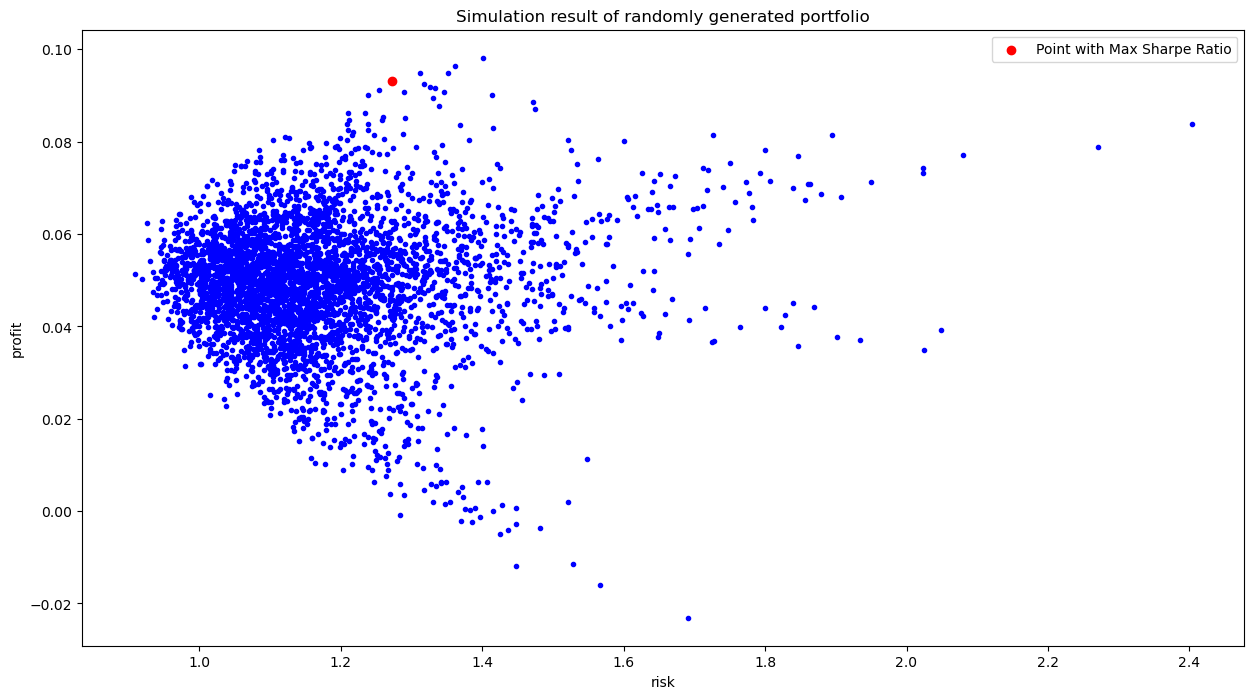

In [8]:
plt.figure(figsize=(15,8))
plt.scatter(risk*100, profit*100, marker='.', color='blue')
plt.xlabel('risk')
plt.ylabel('profit')
plt.title("Simulation result of randomly generated portfolio")
maxSharpeRatioPoint = np.argmax(np.divide(profit, risk))
plt.scatter(risk[maxSharpeRatioPoint]*100,
            profit[maxSharpeRatioPoint]*100,
            marker='o', color='red', label='Point with Max Sharpe Ratio')
plt.legend()

#### Obtain portfolio with max Sharpe Ratio

In [16]:
optimal_portfolio = portfolio_sim[maxSharpeRatioPoint]

103.66083476153295

In [13]:
company_dict = {}
for company in company_list:
    company_dict[company] = optimal_portfolio[company_list.index(company)] * 100
company_dict

{'A': 2.739897657921077,
 'AA': 2.9414506694235136,
 'ABC': 3.098409270623388,
 'ABCB': 3.981851767277198,
 'ACLS': 10.580057568015288,
 'ACNB': 11.683119062462183,
 'ADBE': 55.69888058567789,
 'ADP': 5.176579048973704,
 'AEG': 1.416324429712407,
 'AIR': 2.683429939913335}

#### Stock price analysis with Monte-Carlo
- Run simulation and test to see if follows Markov Process

In [10]:
mu = price_series.mean()
sigma = price_series.std()
def monteCarlo(start_price, mu, sigma, simPeriod=365):
    """Run Monte-Carlo simulation for a period of one year"""
    step = 1 / simPeriod
    price = np.zeros(simPeriod)
    price[0] = start_price
    shock = np.zeros(simPeriod)
    drift = np.zeros(simPeriod)
    for i in range(1, simPeriod):
        shock[i] = np.random.normal(loc=mu*step, scale=sigma*np.sqrt(step))
        drift[i] = mu*step
        price[i] = price[i-1] + price[i-1]*(drift[i]+shock[i])
    return price
def simulation(company, simTimes, start_price, simPeriod=365):
    """"Run monte-carlo on specified company for simTimes
    
    Returns
    -------
    simArr: 
        simulation result obtained for #simTimes
    """
    print(f"Running simulation for company {company}")
    simArr = np.zeros(simTimes)
    plt.figure(figsize=(15,8))
    for i in range(simTimes):
        result = monteCarlo(start_price, mu[company], sigma[company], simPeriod)
        simArr[i] = result[simPeriod-1] # assume at last time point, reach stable point
        plt.plot(result) # one year simulation
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title(f'Simulation of {simPeriod}days for {company}')
    plt.savefig(fname=f'..\\figures\\{company}_simulation.png')
    return simArr

In [ ]:
company_stock_sim = {} # simulation result for each company
for i in range(companyNum):
    company_stock_sim[company_list[i]] = \
    simulation(company=company_list[i], simTimes=1000,
            start_price=start_price[i], simPeriod=365)

#### Mean and Variance analysis with Monte-Carlo
- check final price(average) and compare with starting price

In [21]:
sim_mean, sim_std = [], []
for company in company_list:
    company_mean = np.mean(company_stock_sim[company])
    company_std = np.std(company_stock_sim[company])
    sim_mean.append(company_mean)
    sim_std.append(company_std)
frame = np.array([start_price, sim_mean, sim_std])
analysis = pd.DataFrame(frame.T, 
    columns=['Start Price', 'Mean', 'Variance'],
    index=company_list)
analysis

,Start Price,Mean,Variance
A,67.459999,67.565021,0.955854
AA,26.580000,26.633725,0.691524
ABC,74.400002,74.394840,1.122953
ABCB,31.670000,31.675450,0.511469
ACLS,17.799999,17.805871,0.502737
ACNB,39.250000,39.308225,0.561389
ADBE,226.240005,226.945456,3.786279
ADP,131.119995,131.201571,1.568437
AEG,4.650000,4.646479,0.088949
AIR,37.340000,37.344916,0.728242
